## 데이터셋 설명
- 본 데이터셋은 텍스트 정보와 직무에 대한 메타 정보로 구성되어 있습니다.
- 데이터셋에는 길이 제한이 없는 잡 포스팅과, 해당 포스팅이 진짜인지, 혹은 가짜인지의 여부가 포함되어 있습니다.
- 자연어(Natrual Language) 데이터, 그 중에서도 영어 데이터를 전처리하여 텍스트 데이터를 딥러닝에 적용하는 과정을 통해, 데이터 전처리와 특징 추출의 과정을 배워보시길 바랍니다.

## 자연어 처리 (Natural Language Processing, NLP)
- 자연어 데이터를 머신러닝에 사용하기 위해서는 데이터를 머신러닝에 사용할 수 있도록 전처리하는 과정이 필요합니다.
- 일반적으로 머신러닝에 사용되는 데이터가 어떤 형태이고, 자연어가 이와 어떻게 다른지 생각해봅시다.
    - 데이터의 크기: 대부분의 머신러닝 모델들은 고정된 크기의 입력 데이터를 받습니다. 그러나, 자연어는 문장에 따라 길이가 상이합니다. 때문에 자연어를 머신러닝 모델에 투입하려면 데이터를 고정된 크기로 변환해줘야 합니다.
    - 데이터의 형태: 머신러닝 모델들은 실수 데이터를 입력 받습니다. 그러나, 자연어 데이터는 문자형(char, string)으로 되어있습니다.
- 이러한 문제들로 자연어 처리에서는 전처리 방식이 매우 중요합니다.

In [1]:
# 라이브러리 임포트
import os
import random
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm

from sklearn.metrics import accuracy_score

import torchvision
from torchvision.models import VGG16_Weights
from torchvision.transforms import v2

In [2]:
# 하이퍼파라미터
args = {
    "train_path" : "/kaggle/input/2024-outta-basic-p-1/train.csv",      # train 데이터 경로
    "test_path" : "/kaggle/input/2024-outta-basic-p-1/test.csv",       # test 데이터 경로
    "submit_path" : "/kaggle/input/2024-outta-basic-p-1/sample_submission.csv",     # submit 파일 경로
    "batch_size" : 128,
    "epochs" : 30,
    "lr" : 2e-4,
    "seed_val" : 42         # 절대 수정하지 마세요.
}

In [3]:
# 랜덤시드 고정하기
seed = args["seed_val"]
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available() : 
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# 디바이스 선택
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

In [5]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print(f"mps is selected for m1. device : {device}")

In [6]:
# ! 와 %의 차이는 %썼을 때 프로세스 유지
%pip install torchsummary ## model을 요약하기 위해 torchsummary 설치

Note: you may need to restart the kernel to use updated packages.


In [7]:
from torchsummary import summary as summary_## 모델 정보를 확인하기 위해 torchsummary 함수 import

## 모델의 형태를 출력하기 위한 함수 
def summary_model(model, input_shape=(3,32,32)):
    model = model.to(device)
    summary_(model, input_shape) ## (model, (input shape))

# **1. 데이터셋**

## **(1) 데이터 불러오기 및 전처리**

In [8]:
# 훈련 및 테스트 데이터 로드
train = pd.read_csv(args['train_path'])
test = pd.read_csv(args['test_path'])

In [9]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [10]:
# (1-1) 훈련 데이터에서 특징(x_train)과 라벨(y_train) 분리
x_train = train.iloc[:, 1:]   # 첫 번째 열을 제외한 모든 열 (특징)
y_train = train['label']  # 'label' 열 (라벨)
x_test = test.iloc[:, :]   # 테스트 데이터

In [11]:
x_train.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,107,118,127,134,139,143,146,150,153,156,...,207,207,207,207,206,206,206,204,203,202
1,155,157,156,156,156,157,156,158,158,157,...,69,149,128,87,94,163,175,103,135,149
2,187,188,188,187,187,186,187,188,187,186,...,202,201,200,199,198,199,198,195,194,195
3,211,211,212,212,211,210,211,210,210,211,...,235,234,233,231,230,226,225,222,229,163
4,164,167,170,172,176,179,180,184,185,186,...,92,105,105,108,133,163,157,163,164,179


In [12]:
y_train.head()

0     3
1     6
2     2
3     2
4    13
Name: label, dtype: int64

In [13]:
x_test.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,149,149,150,150,150,151,151,150,151,152,...,138,148,127,89,82,96,106,112,120,107
1,126,128,131,132,133,134,135,135,136,138,...,47,104,194,183,186,184,184,184,182,180
2,85,88,92,96,105,123,135,143,147,152,...,68,166,242,227,230,227,226,225,224,222
3,203,205,207,206,207,209,210,209,210,209,...,154,248,247,248,253,236,230,240,253,255
4,188,191,193,195,199,201,202,203,203,203,...,26,40,64,48,29,46,49,46,46,53


In [14]:
# (1-2) numpy 배열로 변환 후, torch Tensor로 변환
x_train = torch.tensor(x_train.values, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.int64)
#y_train = y_train.type(torch.long)
x_test = torch.tensor(x_test.values, dtype=torch.float32)

In [15]:
x_train.shape, y_train.shape, x_test.shape

(torch.Size([27455, 784]), torch.Size([27455]), torch.Size([7172, 784]))

In [16]:
x_train.dtype, y_train.dtype, x_test.dtype

(torch.float32, torch.int64, torch.float32)

In [17]:
x_train.shape[0]

27455

In [18]:
# (1-3) 데이터를 (N, H, W, C) 형태로 재구성 (reshape 함수 이용)
# 784 = 28*28
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train.shape, x_test.shape

(torch.Size([27455, 28, 28, 1]), torch.Size([7172, 28, 28, 1]))

In [19]:
# (1-4) 데이터를 (N, C, H, W) 형태로 변환 (permute 함수 이용)
x_train = x_train.permute(0,3,1,2)
x_test = x_test.permute(0,3,1,2)
x_train.shape, x_test.shape

(torch.Size([27455, 1, 28, 28]), torch.Size([7172, 1, 28, 28]))

In [20]:
# (1-5) 데이터를 (N, 3, 28, 28) 형태로 변환 (expand 함수 이용)
x_train = x_train.expand(-1, 3, -1, -1)
x_test = x_test.expand(-1, 3, -1, -1)
x_train.shape, x_test.shape

(torch.Size([27455, 3, 28, 28]), torch.Size([7172, 3, 28, 28]))

In [21]:
x_train.shape

torch.Size([27455, 3, 28, 28])

In [22]:
y_train.shape, y_train.dtype

(torch.Size([27455]), torch.int64)

In [23]:
x_test.shape

torch.Size([7172, 3, 28, 28])

## **(2) 데이터셋과 데이터로더**

In [24]:
# 훈련 및 테스트 데이터셋 로드
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test)

# 데이터로더 정의
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=args["batch_size"], shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

In [25]:
for sample in test_dataloader:
    print(sample[0].shape)
    break
    

torch.Size([1, 3, 28, 28])


# **2. 모델**
사전학습된 VGG16을 사용하여 프로젝트를 수행하세요.

## **(1) VGG16 특징 추출기를 불러오기**

In [26]:
# (3-1) VGG16 모델 로드 및 특징 추출 부분 사용
# 가중치는 'VGG16_Weights.IMAGENET1K_V1' 사용하세요.
model = torchvision.models.vgg16(weights=VGG16_Weights.IMAGENET1K_V1).features

# (3-2) 모델에 글로벌 평균 풀링 계층 추가
# global avg pooling 의 경우, 최종 층에 사용하는 pooling으로 각층의 모든 feature를 1*1의 출력으로 만든다. 따라서 kernel_size는 input과 동일해야 한다.
# 기존 vgg16 마지막 출력이 1*1 사이즈이므로, 이 경우, kernel_size는 1이 되어야 한다. 
model.global_avg_pool2d = nn.AvgPool2d(kernel_size=1)

# 모델 요약 정보 출력
summary_model(model)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 140MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

## **(2) VGG16 특징 추출기를 동결시키기**
1. 계산 비용 절감:
    - 모델의 일부 파라미터를 동결하면 그 부분은 학습되지 않기 때문에 계산량이 줄어듭니다. 

    - 이는 학습 속도를 빠르게 하고, GPU 메모리 사용량을 줄이는 데 도움이 됩니다.

2. 오버피팅 방지:
    - 작은 데이터셋을 사용할 때 모델이 쉽게 오버피팅될 수 있습니다. 
    
    - 이미 학습된 파라미터를 동결하면 모델이 새로운 데이터에 맞춰 과도하게 학습되는 것을 방지할 수 있습니다.


3. 전이 학습(Transfer Learning):
    - 사전 학습된 모델(예: ImageNet 데이터셋으로 학습된 모델)의 초반 레이어는 일반적인 특징(예: 에지, 텍스처 등)을 잘 잡아냅니다. 

    - 이러한 특징을 이용하면 새로운 데이터셋에서도 좋은 성능을 낼 수 있습니다. 

    - 모델의 후반 레이어만 재학습하여 새로운 데이터셋에 맞출 수 있습니다.

4. 더 빠른 수렴:
    - 동결된 파라미터는 변화하지 않으므로 모델이 더 빠르게 수렴할 수 있습니다. 
    
    - 이는 전체 학습 시간을 단축시키는 데 도움이 됩니다.

In [27]:
# 모델의 앞부분 파라미터 고정 (동결) -> 동결하지 않고 다 사용.
"""
for para in model[:-30].parameters(): 
    para.requires_grad = False
"""


# 파라미터 동결 후 모델 요약 정보 출력
summary_model(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

## **(3) VGG16 분류기를 만들기**

In [28]:
# (4-1) 새로운 분류기 정의
classifier = nn.Sequential(
    # 25개의 클래스로 분류
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(512, 64), # feature extractor의 최종 output이 (N, 512, 1, 1)이므로
    nn.BatchNorm1d(64), #배치 정규화, 학습 안정
    #nn.ReLU(),
    nn.Dropout(0.5),    #dropout -> overfitting 방지
    nn.Linear(64, 32), # feature extractor의 최종 output이 (N, 512, 1, 1)이므로
    nn.BatchNorm1d(32), #배치 정규화, 학습 안정
    #nn.ReLU(),
    nn.Dropout(0.3),    #dropout -> overfitting 방지
    nn.Linear(32, 25)   #최종 분류 클래스 개수로
)


# (4-2) 모델에 새로운 분류기 추가
model.classifier = classifier


# 모델을 장치로 이동
model = model.to(device)

# 최종 모델 요약 정보 출력
summary_model(model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          36,928
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
              ReLU-9          [-1, 128, 16, 16]               0
        MaxPool2d-10            [-1, 128, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]         295,168
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 256, 8, 8]         590,080
             ReLU-14            [-1, 25

# **3. 학습**

In [29]:
# VGG16에서 사용한 transform을 이용
transform = VGG16_Weights.DEFAULT.transforms(antialias=False)

# resize 크기는 32가 되도록 설정
transform.resize_size=[32]
transform.crop_size=[32]

# transform 확인하기
print(transform)

ImageClassification(
    crop_size=[32]
    resize_size=[32]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


Epoch 1/30


100%|██████████| 215/215 [00:09<00:00, 22.93it/s]


CheckPoint : model_state_dict_epoch_1.pth
train_loss : 1.411295058006464, train_acc : 0.8385537790697675

Epoch 2/30


100%|██████████| 215/215 [00:08<00:00, 24.23it/s]


CheckPoint : model_state_dict_epoch_2.pth
train_loss : 0.6718108853628469, train_acc : 0.997093023255814

Epoch 3/30


100%|██████████| 215/215 [00:08<00:00, 24.50it/s]


CheckPoint : model_state_dict_epoch_3.pth
train_loss : 0.43721043689306394, train_acc : 0.9990915697674418

Epoch 4/30


100%|██████████| 215/215 [00:08<00:00, 24.56it/s]


CheckPoint : model_state_dict_epoch_4.pth
train_loss : 0.29848137393940327, train_acc : 0.9993459302325581

Epoch 5/30


100%|██████████| 215/215 [00:08<00:00, 24.50it/s]


CheckPoint : model_state_dict_epoch_5.pth
train_loss : 0.21198014194189116, train_acc : 0.9996002906976744

Epoch 6/30


100%|██████████| 215/215 [00:08<00:00, 24.29it/s]


CheckPoint : model_state_dict_epoch_6.pth
train_loss : 0.1598605731198954, train_acc : 0.9994912790697674

Epoch 7/30


100%|██████████| 215/215 [00:08<00:00, 24.49it/s]


CheckPoint : model_state_dict_epoch_7.pth
train_loss : 0.12583802002806996, train_acc : 0.999781976744186

Epoch 8/30


100%|██████████| 215/215 [00:08<00:00, 24.55it/s]


CheckPoint : model_state_dict_epoch_8.pth
train_loss : 0.09879784064237461, train_acc : 0.9996366279069767

Epoch 9/30


100%|██████████| 215/215 [00:08<00:00, 24.19it/s]


CheckPoint : model_state_dict_epoch_9.pth
train_loss : 0.11162129120771275, train_acc : 0.9924418604651163

Epoch 10/30


100%|██████████| 215/215 [00:08<00:00, 24.56it/s]


CheckPoint : model_state_dict_epoch_10.pth
train_loss : 0.07375012092119039, train_acc : 0.9988008720930233

Epoch 11/30


100%|██████████| 215/215 [00:08<00:00, 24.56it/s]


CheckPoint : model_state_dict_epoch_11.pth
train_loss : 0.05563717403037603, train_acc : 0.999781976744186

Epoch 12/30


100%|██████████| 215/215 [00:08<00:00, 24.52it/s]


CheckPoint : model_state_dict_epoch_12.pth
train_loss : 0.04760015467398388, train_acc : 0.999781976744186

Epoch 13/30


100%|██████████| 215/215 [00:08<00:00, 24.30it/s]


CheckPoint : model_state_dict_epoch_13.pth
train_loss : 0.04004815198307814, train_acc : 0.9997093023255814

Epoch 14/30


100%|██████████| 215/215 [00:08<00:00, 24.44it/s]


CheckPoint : model_state_dict_epoch_14.pth
train_loss : 0.035104777698600015, train_acc : 0.9999273255813953

Epoch 15/30


100%|██████████| 215/215 [00:08<00:00, 24.43it/s]


CheckPoint : model_state_dict_epoch_15.pth
train_loss : 0.03079309268572996, train_acc : 0.9999273255813953

Epoch 16/30


100%|██████████| 215/215 [00:08<00:00, 24.36it/s]


CheckPoint : model_state_dict_epoch_16.pth
train_loss : 0.026907013607926147, train_acc : 0.999890988372093

Epoch 17/30


100%|██████████| 215/215 [00:08<00:00, 24.62it/s]


CheckPoint : model_state_dict_epoch_17.pth
train_loss : 0.02387329089173744, train_acc : 0.9998183139534884

Epoch 18/30


100%|██████████| 215/215 [00:08<00:00, 24.61it/s]


CheckPoint : model_state_dict_epoch_18.pth
train_loss : 0.020843323632035143, train_acc : 0.9999636627906977

Epoch 19/30


100%|██████████| 215/215 [00:08<00:00, 24.41it/s]


CheckPoint : model_state_dict_epoch_19.pth
train_loss : 0.018629371305537778, train_acc : 0.9997456395348837

Epoch 20/30


100%|██████████| 215/215 [00:08<00:00, 24.38it/s]


CheckPoint : model_state_dict_epoch_20.pth
train_loss : 0.016388451767175696, train_acc : 0.9999636627906977

Epoch 21/30


100%|██████████| 215/215 [00:08<00:00, 24.49it/s]


CheckPoint : model_state_dict_epoch_21.pth
train_loss : 0.015568173440649759, train_acc : 0.9998183139534884

Epoch 22/30


100%|██████████| 215/215 [00:08<00:00, 24.59it/s]


CheckPoint : model_state_dict_epoch_22.pth
train_loss : 0.013746893427572971, train_acc : 0.9998546511627907

Epoch 23/30


100%|██████████| 215/215 [00:08<00:00, 24.38it/s]


CheckPoint : model_state_dict_epoch_23.pth
train_loss : 0.012697926328279251, train_acc : 0.999890988372093

Epoch 24/30


100%|██████████| 215/215 [00:08<00:00, 24.44it/s]


CheckPoint : model_state_dict_epoch_24.pth
train_loss : 0.011156891019971565, train_acc : 0.9998546511627907

Epoch 25/30


100%|██████████| 215/215 [00:08<00:00, 24.49it/s]


CheckPoint : model_state_dict_epoch_25.pth
train_loss : 0.009936314121668422, train_acc : 0.9998183139534884

Epoch 26/30


100%|██████████| 215/215 [00:08<00:00, 24.38it/s]


CheckPoint : model_state_dict_epoch_26.pth
train_loss : 0.009382921108586151, train_acc : 0.9999636627906977

Epoch 27/30


100%|██████████| 215/215 [00:08<00:00, 24.30it/s]


CheckPoint : model_state_dict_epoch_27.pth
train_loss : 0.00880950165067821, train_acc : 0.999781976744186

Epoch 28/30


100%|██████████| 215/215 [00:08<00:00, 24.59it/s]


CheckPoint : model_state_dict_epoch_28.pth
train_loss : 0.007658214459932128, train_acc : 0.999890988372093

Epoch 29/30


100%|██████████| 215/215 [00:08<00:00, 24.53it/s]


CheckPoint : model_state_dict_epoch_29.pth
train_loss : 0.006890996138370314, train_acc : 0.9999636627906977

Epoch 30/30


100%|██████████| 215/215 [00:08<00:00, 24.36it/s]


CheckPoint : model_state_dict_epoch_30.pth
train_loss : 0.006308314144654676, train_acc : 0.9999636627906977



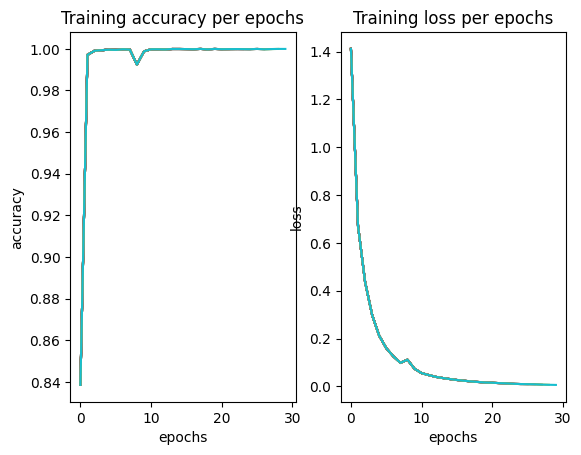

In [30]:
acc_list = []
loss_list = []

def train(train_dataloader, model, device, args):
    """
    주어진 데이터로 모델을 학습시키는 함수입니다.

    Args:
        train_dataloader (DataLoader): 학습 데이터를 제공하는 DataLoader 객체
        valid_dataloader (DataLoader): 검증 데이터를 제공하는 DataLoader 객체
        model (torch.nn.Module): 학습할 모델
        device (torch.device): 사용할 디바이스 (CPU 또는 GPU)
        args (dict): 학습 관련 인자들을 포함한 딕셔너리

    Returns:
        None
    """
    
    
    # (5-1) Adam 옵티마이저와 교차 엔트로피 손실 함수 정의
    optimizer = optim.Adam(params=model.parameters(), lr= args['lr']) 
    loss_fn = nn.CrossEntropyLoss()
    
    model.zero_grad()  # 모델의 그래디언트 초기화
    
    for epoch in range(args["epochs"]):
        model.train()       # 모델을 훈련 모드로 설정
        
        total_loss = 0      # 전체 손실 초기화
        total_accuracy = 0  # 전체 정확도 초기화
        
        print(f'Epoch {epoch + 1}/{args["epochs"]}')
        
        for image, label in tqdm(train_dataloader):
            image = transform(image).to(device)
            label = label.to(device)
            
            # print(image.shape, label.shape)
            # print(image.dtype, label.dtype)
            
            
            # (5-2) 모델을 사용하여 예측 수행
            pred = model(image)
            
            # (5-3) 손실 계산 및 누적
            loss = loss_fn(pred, label)
            
            # (5-4) 역전파를 통해 기울기 계산
            loss.backward()
            
            # (5-5) 파라미터 업데이트
            optimizer.step()
            
            # (5-6) 모델의 그래디언트 초기화
            optimizer.zero_grad()
            
            # loss 계산
            total_loss += loss.item()
            
            # accaracy 계산
            label = label.cpu()
            pred = pred.argmax(dim = 1).cpu()
            accuracy = accuracy_score(label, pred)
            total_accuracy += accuracy
        
        # 평균 손실과 정확도 계산
        avg_loss = total_loss / len(train_dataloader)
        avg_accuracy = total_accuracy / len(train_dataloader)
        
        loss_list.append(avg_loss)
        acc_list.append(avg_accuracy)
        
        plt.subplot(121)
        plt.plot(acc_list)
        plt.title('Training accuracy per epochs')
        plt.xlabel('epochs')
        plt.ylabel('accuracy')

        plt.subplot(122)
        plt.plot(loss_list)
        plt.title('Training loss per epochs')
        plt.xlabel('epochs')
        plt.ylabel('loss')
        
        # 모델 체크포인트 저장
        os.makedirs("results", exist_ok=True)
        torch.save({
            'epoch': epoch,
            'model': model,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item,
            }, f'./results/model_state_dict_epoch_{epoch+1}.pth')
        
        # 현재 에포크의 손실과 정확도 출력
        print(f'CheckPoint : model_state_dict_epoch_{epoch+1}.pth')
        print(f'train_loss : {avg_loss}, train_acc : {avg_accuracy}\n')
    
if __name__ == "__main__":
    train(train_dataloader, model, device, args)

# **4. 평가**

In [31]:
max_value = 0
max_index = 0
min_loss = 100

for step, acc in enumerate(acc_list):
    if max_value <= acc and min_loss >= loss_list[step]:
        max_value = acc
        max_index = step
        min_loss = loss_list[step]
print(max_value, max_index, min_loss)


0.9999636627906977 29 0.006308314144654676


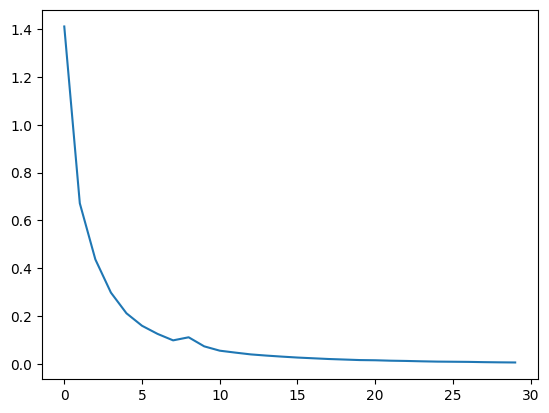

In [32]:
plt.plot(loss_list)

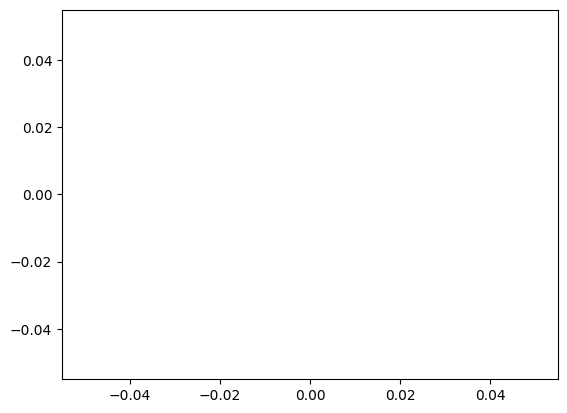

In [33]:
plt.plot(acc_list[50:])

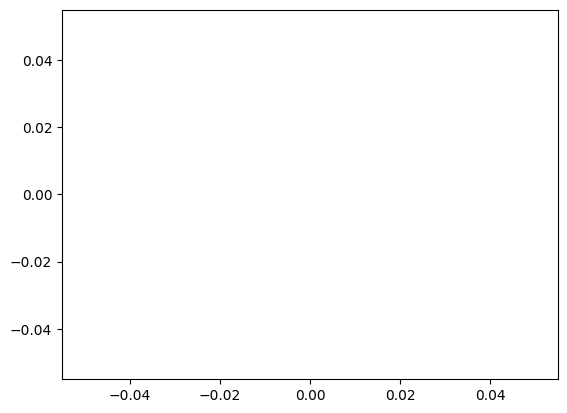

In [34]:
plt.plot(loss_list[50:])

In [35]:
checkpoint = torch.load(f"/kaggle/working/results/model_state_dict_epoch_{max_index +1}.pth", map_location=device)

model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [36]:
def test(test_dataloader, model, device):
    """
    모델의 테스트를 수행하는 함수입니다.

    Args:
        test_dataloader (DataLoader): 테스트 데이터를 제공하는 DataLoader 객체
        model (torch.nn.Module): 평가할 모델
        device (torch.device): 사용할 디바이스 (CPU 또는 GPU)

    Returns:
        preds (list): 각 입력 예시에 대한 모델의 예측 결과 리스트
    """
    model.eval()    # 모델을 평가 모드로 설정
    preds = []      # 예측 결과를 저장할 리스트
    
    # 각 배치에 대해 예측 수행
    for image in tqdm(test_dataloader):
        
        # test_set에는 label이 잆으므로, 0번인 img data만 가져온다.
        # test는 batch_size 가 1이다. -> input_shape : (1,3,28,28)
        # transform 해주면, (1,3,32,32)
        image = transform(image[0]).to(device)
        
        # 기울기 계산을 비활성화하여 예측 수행
        with torch.no_grad():
            # (6-1) 모델에 입력을 전달하여 예측 수행
            # shape : [1, 25]
            pred = model(image)
            
            # (6-2) argmax를 이용하여 예측 결과에서 가장 높은 값의 인덱스를 선택
            pred_index = pred.argmax()
            
            # (6-3) 예측 결과를 CPU로 이동
            pred_index = pred_index.cpu()

            # (6-4) 예측을 numpy 배열로 변환
            pred_index = pred_index.detach().numpy()

            # (6-5) 예측 결과를 리스트에 추가
            preds.append(pred_index)
    
    return preds


if __name__ == "__main__":
    # 예측값을 얻기 위해 test 함수 호출
    preds = test(test_dataloader, model, device)

100%|██████████| 7172/7172 [00:18<00:00, 393.30it/s]


In [37]:
submit = pd.read_csv(args["submit_path"])
submit["label"] = preds
submit.to_csv("submission.csv", index = False)

In [38]:
submit

,id,label
0,0,6
1,1,5
2,2,10
3,3,0
4,4,3
...,...,...
7167,7167,1
7168,7168,12
7169,7169,2
7170,7170,4


In [39]:
%ls

__notebook__.ipynb  results/  submission.csv
